In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data_path = "../data/processed/features.csv"
df = pd.read_csv(data_path)

print("✅ Loaded dataset:", df.shape)
print(df.head())

✅ Loaded dataset: (2833, 11)
   defect_code     mean_R     mean_G     mean_B      std_R      std_G  \
0            0  75.373413  39.617188  23.330566  34.021075  24.308349   
1            0  79.043579  42.547974  24.335571  32.848480  23.765535   
2            1  78.707214  42.473450  24.625061  33.242653  23.830912   
3            0  78.964783  42.764648  24.944946  33.487846  24.235159   
4            0  79.308594  43.271423  25.482056  33.818597  24.076371   

       std_B   contrast  smoothness      entropy  edge_density  
0  17.515105  22.761960    0.042084  6115.776330      0.354004  
1  17.445949  22.255746    0.043000  6374.644691      0.355957  
2  17.578732  22.406508    0.042723  6370.795024      0.344666  
3  17.820972  22.716422    0.042165  6380.411239      0.347900  
4  17.908623  22.688086    0.042215  6424.369858      0.347595  


In [15]:
X = df.drop(columns=["defect_code"])
y = df["defect_code"]

# Remove very rare defect codes (less than 10 samples)
counts = y.value_counts()
rare_classes = counts[counts < 10].index
mask = ~y.isin(rare_classes)
X, y = X[mask], y[mask]

print(f"✅ Classes after removing rare ones: {y.nunique()}")
print(y.value_counts().head())

✅ Classes after removing rare ones: 15
defect_code
0     2118
2      113
1      110
16      96
32      40
Name: count, dtype: int64


In [16]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(f"✅ After SMOTE: {X_res.shape[0]} samples | Classes: {len(np.unique(y_res))}")


✅ After SMOTE: 31770 samples | Classes: 15


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42,
        use_label_encoder=False
    ),
}


In [21]:
results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    if name == "XGBoost":
        model.fit(X_train_scaled, y_train_enc)
        y_pred = le.inverse_transform(model.predict(X_test_scaled))
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"✅ {name} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    results[name] = {"Accuracy": acc, "F1": f1, "Model": model}



🔹 Training Logistic Regression...
✅ Logistic Regression | Accuracy: 0.3031 | F1-score: 0.2754
              precision    recall  f1-score   support

           0       0.16      0.04      0.06       400
           1       0.28      0.14      0.19       435
           2       0.18      0.07      0.10       441
           3       0.35      0.33      0.34       415
           4       0.30      0.08      0.13       436
           5       0.43      0.08      0.13       451
           6       0.38      0.45      0.41       431
           9       0.51      0.44      0.47       434
          10       0.40      0.36      0.38       422
          13       0.27      0.29      0.28       407
          16       0.17      0.35      0.23       434
          18       0.28      0.79      0.41       414
          19       0.33      0.57      0.42       427
          20       0.37      0.20      0.26       406
          32       0.28      0.38      0.33       401

    accuracy                           

d:\SmartMill_Analytics\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [10:16:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost | Accuracy: 0.8264 | F1-score: 0.8221
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.84      0.77      0.80       435
           2       0.78      0.68      0.73       441
           3       0.84      0.90      0.87       415
           4       0.76      0.74      0.75       436
           5       0.75      0.78      0.77       451
           6       0.79      0.92      0.85       431
           9       0.80      0.85      0.82       434
          10       0.87      0.83      0.85       422
          13       0.85      0.94      0.90       407
          16       0.88      0.87      0.87       434
          18       0.84      0.94      0.89       414
          19       0.90      0.94      0.92       427
          20       0.84      0.91      0.88       406
          32       0.88      0.86      0.87       401

    accuracy                           0.83      6354
   macro avg       0.83      0.8

In [22]:
results_df = pd.DataFrame(results).T.sort_values(by="F1", ascending=False)
print("\n📊 Model Comparison:\n", results_df)


📊 Model Comparison:
                      Accuracy        F1  \
Random Forest         0.91108  0.907539   
XGBoost              0.826409  0.822131   
Logistic Regression  0.303116  0.275423   

                                                                 Model  
Random Forest        (DecisionTreeClassifier(max_features='sqrt', r...  
XGBoost              XGBClassifier(base_score=None, booster=None, c...  
Logistic Regression  LogisticRegression(max_iter=1000, random_state...  


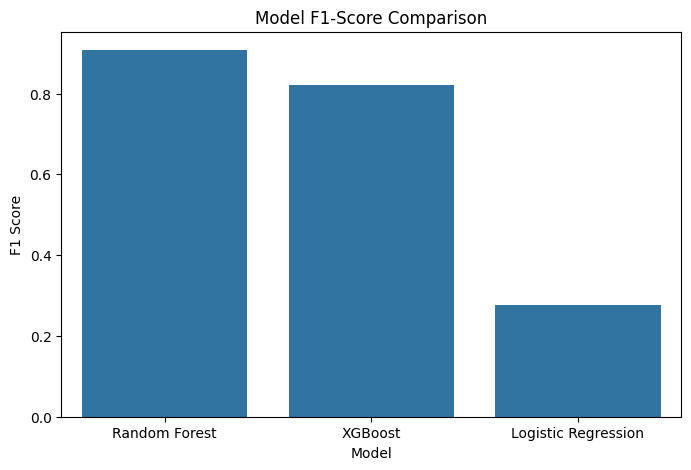

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y=results_df["F1"])
plt.title("Model F1-Score Comparison")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.show()

In [25]:
import os
import joblib

# Ensure the folder exists
os.makedirs("../models", exist_ok=True)

# Save best model
best_model_name = results_df.index[0]
best_model = results[best_model_name]["Model"]
joblib.dump(best_model, f"../models/{best_model_name.replace(' ', '_')}_best.pkl")

print(f"\n💾 Best model saved: {best_model_name}")



💾 Best model saved: Random Forest
